In [1]:
# Importing libraries

import pandas as pd 
import numpy as np
from numpy import float32
from tqdm import tqdm

from typing import Optional
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, confusion_matrix, precision_score,roc_auc_score,f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.multiprocessing import set_start_method

import pytorch_lightning as pl

from torch.utils.data import DataLoader, Dataset
import os

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
random_seed = 123
torch.manual_seed(random_seed)

BATCH_SIZE=1000
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
#df = pd.read_csv("/kaggle/input/credit-card-fraud/card_transdata.csv")
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
#df = df.drop(['type','nameDest','nameOrign'],axis=1)
from sklearn.preprocessing import StandardScaler
Mx = df.iloc[:, :-1]  # without Class
nx = df.iloc[:, -1]   # Class

# Create StandardScaler
scaler = StandardScaler()

# Fitting and transforming features
Mx_scaled = pd.DataFrame(scaler.fit_transform(Mx), columns=Mx.columns)

scaled_data = pd.concat([Mx_scaled, nx], axis=1)

scaled_data.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964,0
1,-1.996583,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,...,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475,0
2,-1.996562,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,...,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686,0
3,-1.996562,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,...,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534,0
4,-1.996541,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,...,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403,0


In [4]:
# Creating function to plot confusion metrics for evaluation
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [5]:
train, test = train_test_split(df, test_size=0.2, stratify=df['Class'])
train.shape, test.shape

((227845, 31), (56962, 31))

In [6]:
# Normalizing the data
data_mean = train.iloc[:,:-1].mean()
data_std = train.iloc[:,:-1].std()
train_norm = (train.iloc[:,:-1] - data_mean)/data_std
test_norm = (test.iloc[:,:-1] - data_mean)/data_std
train_norm['Class'] =  train.iloc[:, -1]
test_norm['Class'] =  test.iloc[:, -1]

In [7]:
train_norm['Class'].value_counts()

Class
0    227451
1       394
Name: count, dtype: int64

In [8]:
# Creating data model to use with the pytorch Lightning package
class CreditCardDataFinal(Dataset):
    def __init__(self, data: pd.DataFrame):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        label = torch.tensor(self.data[index][-1], dtype=torch.float32)
        row = torch.tensor(self.data[index][:-1], dtype=torch.float32)
        return row, label
    
class CreditCardDataModel(pl.LightningDataModule):
    def __init__(self, data: pd.DataFrame, batch_size=BATCH_SIZE, num_workers=0):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.num_workers = num_workers
    
    def setup(self, stage: Optional[str] = None):
        train_df, test_df = train_test_split(self.data, random_state=123, test_size=0.2, stratify=self.data['Class'])
        self.train_df = torch.tensor(train_norm.to_numpy(float32), dtype=torch.float32)
        self.test_df = torch.tensor(test_norm.to_numpy(float32), dtype=torch.float32)

    def train_dataloader(self):
        return DataLoader(dataset=CreditCardDataFinal(self.train_df), batch_size=self.batch_size, num_workers=self.num_workers)
    
    def test_dataloader(self):
        return DataLoader(dataset=CreditCardDataFinal(self.test_df), batch_size=self.batch_size, num_workers=self.num_workers)
    

In [9]:
# Building the main neural network to predict if the data is fraud or not. 
class ModelCreditCard(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 150),
            nn.LeakyReLU(0.1),
            nn.Linear(150, 50),
            nn.LeakyReLU(0.1),
            nn.Linear(50, 25),
            nn.LeakyReLU(0.1),
            nn.Linear(25, 1)
        )
    
    def forward(self, x):
        tensor = torch.sigmoid(self.sequential(x))
        return tensor
    

class ModelTraining(pl.LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        y_hat = self.model(x)
        y = y.unsqueeze(1)
        loss = self.binary_loss(y_hat, y)
        return {"loss":loss}
    
    def binary_loss(self, y_hat,y):
        return F.binary_cross_entropy(y_hat, y)
    
    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.model.parameters(), lr )
        return [opt_g], []

In [10]:
trainer = pl.Trainer(max_epochs=10, accelerator='cuda', devices=1)

# Creating synthetic Data with GA-GANs

In [11]:
class CreditCardData(Dataset):
    def __init__(self, data: pd.DataFrame):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = torch.tensor(self.data.iloc[index].values).float()
        return row

In [12]:
class DataModule(pl.LightningDataModule):
    def __init__(self, data: pd.DataFrame, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.data_mean = None
        self.data_std = None
        
    def prepare_data(self):
        pass
    
    def setup(self, stage: Optional[str] = None):
        train_df, test_df = train_test_split(self.data, random_state=123, test_size=0.2)
        self.data_mean = train_df.mean()
        self.data_std = train_df.std()
        train_norm = (train_df - self.data_mean) / self.data_std
        test_norm = (test_df - self.data_mean) / self.data_std
        self.train_df = train_norm
        self.test_df = test_norm
    
    def train_dataloader(self):
        return DataLoader(dataset=CreditCardData(self.train_df), batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True)
    
    def valid_dataloader(self):
        return DataLoader(CreditCardData(self.val_df), batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True)
    
    def test_dataloader(self):
        return DataLoader(CreditCardData(self.test_df), batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True)
        

In [13]:
class GatedSelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(GatedSelfAttention, self).__init__()
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.gate = nn.Linear(input_dim, input_dim)  # Additional Gated control layer

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        G = torch.sigmoid(self.gate(x))  
        
        # Calculating Attention Weights
        attention_scores = torch.bmm(Q, K.transpose(1, 2)) / (x.size(-1) ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)
        
        # Apply the gating mechanism to the value vector
        gated_V = V * G
        
        # Vector of values after applying attention weights to gating 
        attention_output = torch.bmm(attention_weights, gated_V)
        
        return attention_output

In [14]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=30):
        super(Discriminator, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            #nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            #nn.LeakyReLU(0.2)
        )
        
        self.attention = GatedSelfAttention(32)
        
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        # Reshape input: (batch_size, features) -> (batch_size, 1, features)
        x = x.unsqueeze(1)
        
        # Apply convolutional layers
        x = self.conv_layers(x)
        
        # Apply self-attention
        x = x.transpose(1, 2)  # (batch_size, 64, features)
        x = self.attention(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Apply fully connected layers
        x = self.fc_layers(x)
        
        return torch.sigmoid(x)

In [15]:
##Generator
class VAEGenerator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.output_dim = output_dim

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Sigmoid() 
        )

    def forward(self, z):
        return self.decoder(z)

In [16]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.002):
        super().__init__()
        self.save_hyperparameters()
        
        self.generator = VAEGenerator(latent_dim=self.hparams.latent_dim,output_dim=30)  # output dim is 30
        self.discriminator = Discriminator()
        
        self.validation_z = torch.randn(6, self.hparams.latent_dim).to(self.device)

        self.automatic_optimization = False  # Disable automatic optimization
        
    def setup(self, stage):
        # Get Data Module
        data_module = self.trainer.datamodule
        
        # Obtaining statistical information on data
        self.data_mean = torch.tensor(data_module.data_mean.values, dtype=torch.float32)
        self.data_std = torch.tensor(data_module.data_std.values, dtype=torch.float32)

    def forward(self, z):
        # Generation of standardized data
        x_normalized = self.generator(z)
        x = x_normalized 
        # or x = x_normalized * self.data_std + self.data_mean
        return x
    
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    def training_step(self, batch, batch_idx):
        real_data = batch #.to(self.device)
        z = torch.randn(real_data.size(0), self.hparams.latent_dim).to(self.device)
        
        # Access optimizers manually
        opt_g, opt_d = self.optimizers()
        
        # Train Complementary GAN:
        
        # Train CCFD-generator: max log(D(G(z)))
        fake_data = self.generator(z)
        y_hat_fake = self.discriminator(fake_data)
        g_loss = self.adversarial_loss(y_hat_fake, torch.ones_like(y_hat_fake))
        
        opt_g.zero_grad()
        self.manual_backward(g_loss)
        opt_g.step()
        
        # Train CCFD-discriminator: max log(D(x)) + log(1- D(G(z)))
        y_hat_real = self.discriminator(real_data)
        y_real = torch.ones(real_data.size(0), 1).to(self.device)
        real_loss = self.adversarial_loss(y_hat_real, y_real)
        
        y_hat_fake = self.discriminator(fake_data.detach())
        y_fake = torch.zeros(real_data.size(0), 1).to(self.device)
        fake_loss = self.adversarial_loss(y_hat_fake, y_fake)
        
        d_loss = (real_loss + fake_loss) / 2
        
        opt_d.zero_grad()
        self.manual_backward(d_loss)
        opt_d.step()
        
        self.log("g_loss", g_loss, prog_bar=True, logger=True)
        self.log("d_loss", d_loss, prog_bar=True, logger=True)
        
    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr)
        return [opt_g, opt_d]

In [17]:
only_pos = train_norm[train_norm['Class'] == 1 ].copy()
only_pos = only_pos.drop(['Class'], axis=1)
only_pos.shape

(394, 30)

In [18]:
model = GAN()
model = model.to(device)

In [19]:
!pip install fvcore
from fvcore.nn import FlopCountAnalysis

model.eval() 
inputs = torch.randn(1,394,100).to(device)  # Create a randomized input tensor

flops = FlopCountAnalysis(model, inputs)
print(f"FLOPs: {flops.total()}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=3f1ec1076f03aae0824e8921dce0c3c45688e786c6623f73038ffc9f678dafa8
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=48a26cf1dc541a4e31c462ce3c5d7445151ae539ca5ecb8e5b26fc662cd3df9b
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
FLOPs: 13011456


In [20]:
dm = DataModule(only_pos)
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, dm)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

In [21]:
z = torch.randn(730078,100)
output = model(z)

z = torch.randn(10000,100,16)
t = torch.randint(0, model.hparams.timesteps, (100, 1), dtype=torch.float, device=model.device)
output = model(z, t)

In [22]:
output

tensor([[0.3067, 0.3479, 0.2023,  ..., 0.2721, 0.2421, 0.3283],
        [0.3419, 0.3498, 0.2162,  ..., 0.2739, 0.3066, 0.3334],
        [0.3646, 0.3679, 0.2173,  ..., 0.2915, 0.3094, 0.3418],
        ...,
        [0.3580, 0.3711, 0.1931,  ..., 0.2891, 0.2770, 0.3332],
        [0.3511, 0.4158, 0.1872,  ..., 0.2612, 0.2725, 0.2916],
        [0.3490, 0.3734, 0.2150,  ..., 0.3087, 0.3250, 0.3494]],
       grad_fn=<SigmoidBackward0>)

In [23]:
only_pos_df =  pd.DataFrame(output.detach().numpy())
only_pos_df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.306692,0.347850,0.202256,0.436613,0.271089,0.294189,0.313494,0.353614,0.294807,0.342944,...,0.314604,0.287869,0.367509,0.288819,0.384039,0.242098,0.423169,0.272056,0.242130,0.328297
1,0.341915,0.349774,0.216183,0.383946,0.297381,0.349957,0.272610,0.360695,0.293968,0.337056,...,0.298169,0.306042,0.370437,0.288877,0.418862,0.296605,0.381021,0.273938,0.306597,0.333409
2,0.364615,0.367886,0.217301,0.338364,0.310227,0.338012,0.329961,0.345928,0.342029,0.388277,...,0.365743,0.307207,0.383089,0.289457,0.381547,0.263180,0.395658,0.291527,0.309445,0.341772
3,0.350871,0.358766,0.257917,0.424533,0.284338,0.392123,0.306778,0.348957,0.330557,0.332762,...,0.354036,0.310483,0.359043,0.358609,0.381587,0.312397,0.413349,0.297628,0.346415,0.377802
4,0.347489,0.387828,0.218447,0.398207,0.319308,0.341445,0.265254,0.342560,0.323548,0.387246,...,0.332050,0.345424,0.385585,0.302915,0.361565,0.255662,0.343905,0.277244,0.278677,0.316888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730073,0.383386,0.407654,0.239308,0.407344,0.323583,0.402887,0.281025,0.320980,0.327994,0.344010,...,0.320887,0.264307,0.339123,0.327057,0.417879,0.333545,0.365461,0.290559,0.349131,0.363986
730074,0.313442,0.373892,0.232141,0.392372,0.279120,0.344409,0.294939,0.339883,0.308050,0.377164,...,0.321963,0.299492,0.343015,0.327251,0.404130,0.318850,0.394815,0.300212,0.352854,0.344091
730075,0.358049,0.371130,0.193058,0.399876,0.278475,0.337981,0.287766,0.348992,0.315055,0.353447,...,0.328396,0.310371,0.347482,0.298543,0.319057,0.301072,0.355386,0.289083,0.276959,0.333191
730076,0.351080,0.415840,0.187177,0.339956,0.269886,0.318982,0.245340,0.337191,0.272317,0.292304,...,0.323305,0.254709,0.344187,0.267418,0.297084,0.215594,0.318343,0.261227,0.272482,0.291605


In [24]:
only_pos_df['Class'] = 1

In [25]:
only_neg_real_df = train_norm[train_norm['Class'] == 0]

In [26]:
train_combined_fake_pos_only = only_pos_df
train_combined_fake_pos_only.columns = only_neg_real_df.columns
train_combined_fake_pos_only = pd.concat([only_pos_df, only_neg_real_df], ignore_index=True)
train_combined_fake_pos_only = train_combined_fake_pos_only.sample(frac=1) # Shuffle the dataset

In [27]:
train_combined_fake_pos_only['Class'].value_counts()

Class
1    730078
0    227451
Name: count, dtype: int64

In [28]:
model_card_with_gan = ModelCreditCard(30)
model_gan = ModelTraining(model_card_with_gan)
dm_only_gan = CreditCardDataModel(train_combined_fake_pos_only)
trainer = pl.Trainer(max_epochs=10, accelerator='cuda', devices=1)
trainer.fit(model_gan, dm_only_gan)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_36/2301993358.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.data[index][-1], dtype=torch.float32)
/tmp/ipykernel_36/2301993358.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row = torch.tensor(self.data[index][:-1], dtype=torch.float32)
/tmp/ipykernel_36/1546114938.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
/tmp/ipykernel_36/1546114938.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

In [29]:
test_pred = torch.tensor(test_norm.drop(["Class"], axis=1).to_numpy()).float()
test_true = test_norm['Class'].to_numpy()
test_true = torch.tensor(test_true).unsqueeze(1).float()
test_output_gan = model_card_with_gan.forward(test_pred)
test_pred_gan = [1 if i > 0.5 else 0 for i in test_output_gan]
print(recall_score(test_true, test_pred_gan))

0.7244897959183674


0.7244897959183674


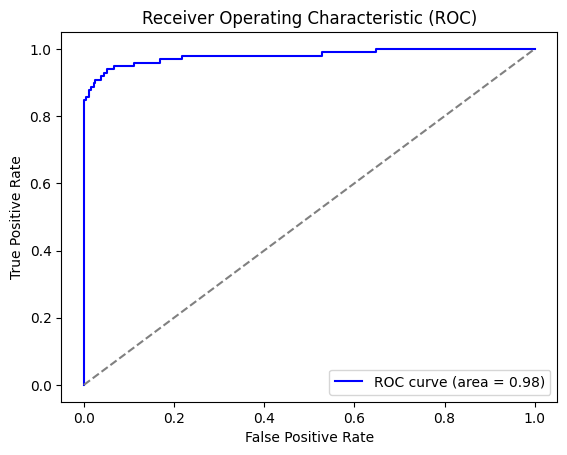

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Compute predictions and probabilities
test_pred_probs = model_card_with_gan.forward(test_pred).detach().numpy()
fpr, tpr, _ = roc_curve(test_true.numpy(), test_pred_probs)
auc_score = roc_auc_score(test_true.numpy(), test_pred_probs)

# Print recall score
print(recall_score(test_true, test_pred_gan))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [31]:
def plot_cm(y_true, y_hat):
    cm = confusion_matrix(test_true, test_pred_gan)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

In [32]:
def evaluate(y_true, y_hat, title):
    print("\n "+ str(title))
    print("Precision Score: ", precision_score(y_true, y_hat))
    print("Recall Score: ", recall_score(y_true, y_hat))
    print("F1 Score: ", f1_score(y_true, y_hat))
    plot_cm(y_true, y_hat)
    plt.show()


 Synthetic Data: Diff-GANs
Precision Score:  0.922077922077922
Recall Score:  0.7244897959183674
F1 Score:  0.8114285714285714


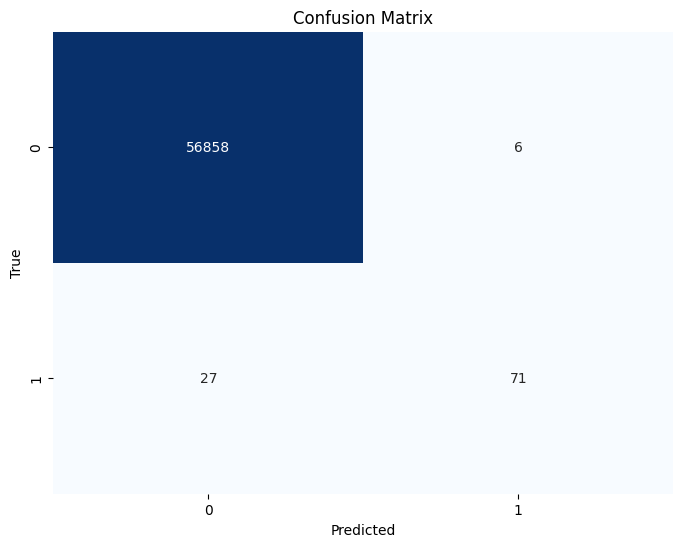

In [33]:
evaluate(test_true, test_pred_gan, "Synthetic Data: Diff-GANs")